# Stats

> Statistics on lensing data

In [ ]:
#| default_exp stats

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from scipy.stats import poisson, norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import differential_evolution
from LensCalcPy.survey import *
from LensCalcPy.parameters import *

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy Model for Mass likelihood

In [ ]:
#| export
# Define the power law function with index -2
def power_law(x, a=1, index=-2):
    return a * (x**index)

# Define the likelihood function for the Poisson process
def likelihood(observed_counts, expected_counts):
    poisson_pmf = poisson.pmf(observed_counts, expected_counts)
    return np.prod(poisson_pmf)

def generate_observed_counts_with_bump(bin_centers, a, index, bump_position, bump_height):
    power_law_counts = power_law(bin_centers, a=a, index=index)
    closest_bin = np.argmin(np.abs(bin_centers - bump_position))
    power_law_counts[closest_bin] += bump_height
    return np.random.poisson(power_law_counts)

## MLE and Log Likelihood Ratio Test

In [ ]:
#| export
# Define the negative log-likelihood function for optimization with continuous bump_position
def neg_log_likelihood(params, bin_centers, observed_counts):
    a, index, bump_position, bump_height = params
    expected_counts = power_law(bin_centers, a=a, index=index)
    closest_bin = np.argmin(np.abs(bin_centers - bump_position))
    expected_counts[closest_bin] += bump_height
    return -np.sum(poisson.logpmf(observed_counts, expected_counts))

def get_MLE_params(bin_centers, observed_counts):
    
    # Set bounds for the parameters
    bounds = [(1, 300), (-4, -1), (min(bin_centers), max(bin_centers)), (0, 200)]

    # Use differential evolution to optimize the parameters
    result_bump = differential_evolution(neg_log_likelihood, bounds=bounds, args=(bin_centers, observed_counts), strategy='best1bin', popsize=10, tol=1e-4)
    optimized_params_bump = result_bump.x
    return optimized_params_bump


In [ ]:
# Generate example observed counts with a bump
a = 200
index = -2
bump_position = 6
bump_height = 20

min_bin = 1
max_bin = 10
bin_edges = np.linspace(min_bin,max_bin,10)  # Assuming bins from -6 to -2
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

observed_counts = generate_observed_counts_with_bump(bin_centers, a, index, bump_position, bump_height)

optimized_params_bump = get_MLE_params(bin_centers, observed_counts)
expected_counts_opt = generate_observed_counts_with_bump(bin_centers, *optimized_params_bump)

print("Optimized parameters: a = {:.2f}, index = {:.2f}, bump_position = {:.2f}, bump_height = {:.2f}".format(*optimized_params_bump))
print("True parameters: a = {:.2f}, index = {:.2f}, bump_position = {:.2e}, bump_height = {:.2f}".format(a, index, bump_position, bump_height))

Optimized parameters: a = 199.45, index = -2.06, bump_position = 5.63, bump_height = 17.01
True parameters: a = 200.00, index = -2.00, bump_position = 6.00e+00, bump_height = 20.00


In [ ]:
#| export
def llr_test(bin_centers, observed_counts):

    optimized_params = get_MLE_params(bin_centers, observed_counts)
    expected_counts_opt = generate_observed_counts_with_bump(bin_centers, *optimized_params)

    # Calculate the likelihood ratio test statistic

    #log likelihood of the null hypothesis (0 bump height)
    ll_null = -neg_log_likelihood([optimized_params[0], optimized_params[1], optimized_params[2], 0], bin_centers, observed_counts)
    #log likelihood of the alternative hypothesis (non-zero bump height)
    ll_alt = -neg_log_likelihood(optimized_params, bin_centers, observed_counts)

    llr = 2 * (ll_alt - ll_null)

    return llr
    

In [ ]:
# Calculate the likelihood ratio test statistic
lr_statistic = llr_test(bin_centers, observed_counts)

# Calculate the p-value using a chi-square distribution
p_value = chi2.sf(lr_statistic, df=2)  # Two degrees of freedom for the difference in number of parameters

# Print the results
print("Likelihood ratio test statistic:", lr_statistic)
print("p-value:", p_value)
if p_value < 0.05:
    print("The null hypothesis is rejected at the 95% significance level.")
else:
    print("The null hypothesis is not rejected at the 95% significance level.")

Likelihood ratio test statistic: 26.61829810637751
p-value: 1.659243050630246e-06
The null hypothesis is rejected at the 95% significance level.


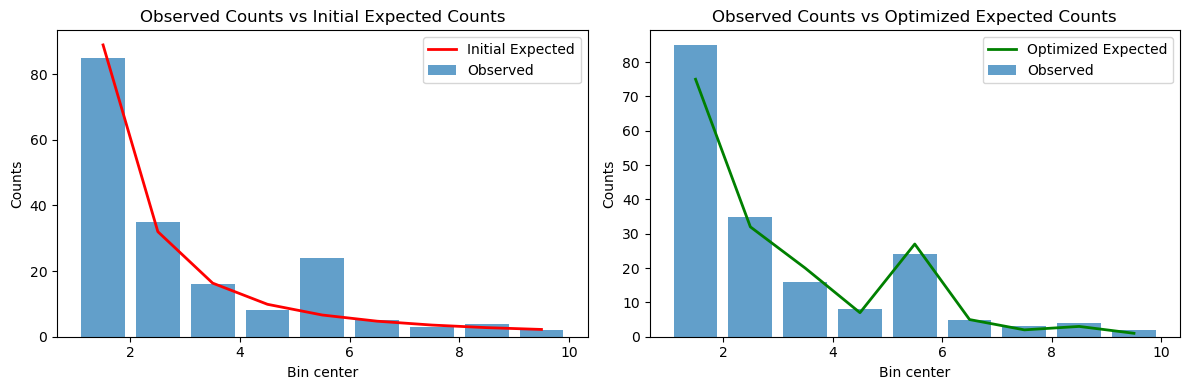

In [ ]:
# Plot the observed counts and the initial/optimized expected counts
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.bar(bin_centers, observed_counts, alpha=0.7, label="Observed")
plt.plot(bin_centers, power_law(bin_centers, a=a, index=index), label="Initial Expected", color='r', linewidth=2)
plt.xlabel("Bin center")
plt.ylabel("Counts")
plt.legend()
plt.title("Observed Counts vs Initial Expected Counts")

plt.subplot(122)
plt.bar(bin_centers, observed_counts, alpha=0.7, label="Observed")
plt.plot(bin_centers, expected_counts_opt, label="Optimized Expected", color='g', linewidth=2)
plt.xlabel("Bin center")
plt.ylabel("Counts")
plt.legend()
plt.title("Observed Counts vs Optimized Expected Counts")

plt.tight_layout()
plt.show()


## Get data from survey to analyze

In [ ]:
m_pbh = 1e-3
f_dm = 1
mlow = 1e-5
alpha = 2

In [ ]:
s = Survey(l, b, ds, obsTime, survey_area, n_sources=n_sources)
s.add_pbh(m_pbh, f_dm)
s.add_ffp(mlow, alpha)
lens_masses = s.get_lens_masses()

10000 500


In [ ]:
#Binning is part of the stats analysis, not inherent to the survey
num_bins = 10
bin_edges = np.logspace(np.log10(min(lens_masses)), np.log10(max(lens_masses)), num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

In [ ]:
#| export
def get_observed_counts(lens_masses, bin_edges):
    observed_counts, _ = np.histogram(lens_masses, bins=bin_edges)
    return observed_counts

In [ ]:
observed_counts = get_observed_counts(lens_masses, bin_edges)

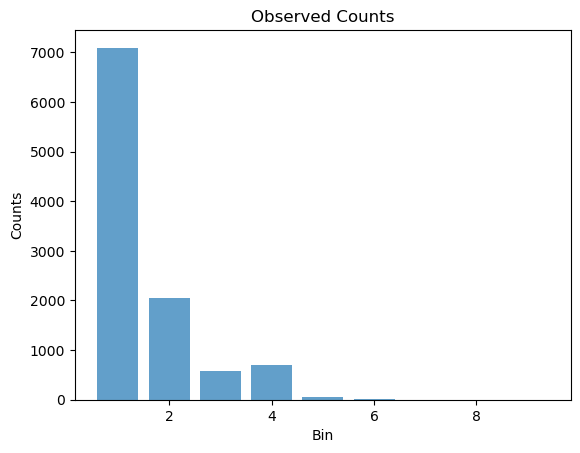

In [ ]:
plt.bar(np.array(range(len(observed_counts)))+1, observed_counts, alpha=0.7)
plt.xlabel("Bin")
plt.ylabel("Counts")
plt.title("Observed Counts")
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()